### Observed Patterns Probability Adjustments
#### Daniel Fay

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import pickle
import itertools
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import normalize
from sklearn.externals import joblib
import plotly.plotly as py
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import random
%matplotlib inline

pd.set_option('display.max_columns', 70)

In [2]:
# Load Data
idap = pd.read_csv('processed_data/IDAP_processed.csv', index_col=0)
rfc_model = joblib.load('processed_data/rfc_model.pkl')

### Define Observed Pattern Adjustment Algorithm

In [3]:
hh_interactions_columns = ['Retiree_NM', 'Retiree_M', 'Retiree_H', 'FT_Worker_NM', 'FT_Worker_M', 'FT_Worker_H', \
                           'PT_Worker_NM', 'PT_Worker_M', 'PT_Worker_H', 'DA_Stud_NM', 'DA_Stud_M', 'DA_Stud_H', \
                           'PreSch_Child_NM', 'PreSch_Child_M', 'PreSch_Child_H', 'PDA_Stud_NM', 'PDA_Stud_M', 'PDA_Stud_H', \
                           'Non_Worker_NM', 'Non_Worker_M', 'Non_Worker_H', 'Univ_Stud_NM', 'Univ_Stud_M', 'Univ_Stud_H']


#idap.drop(hh_interactions_columns, axis=1, inplace=True)
idap.head()

,PERNO,GENDER,PERTYPE,AGE,IDAP,CAR_SUFF,HINCCAT1,EDUCA,JOBS,JOBTYPE,ACCESSIBILITY,DIST,Retiree_NM,Retiree_M,Retiree_H,FT_Worker_NM,FT_Worker_M,FT_Worker_H,PT_Worker_NM,PT_Worker_M,PT_Worker_H,DA_Stud_NM,DA_Stud_M,DA_Stud_H,PreSch_Child_NM,PreSch_Child_M,PreSch_Child_H,PDA_Stud_NM,PDA_Stud_M,PDA_Stud_H,Non_Worker_NM,Non_Worker_M,Non_Worker_H,Univ_Stud_NM,Univ_Stud_M,Univ_Stud_H,H,M,NM,PREDICTION
SAMPN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11002042,1,Female,Retiree,71,NM,More Cars than Workers,"$49,999 or less",Bachelors or Higher Degree,No Job,No Job Type,13.659632,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.00,0.96,NM
11003319,1,Male,FT_Worker,57,M,More Cars than Workers,"$75,000 or more",Bachelors or Higher Degree,One Job,Public Admin,13.652378,3.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.96,0.02,M
11003319,2,Female,PT_Worker,54,M,More Cars than Workers,"$75,000 or more",Less than Bachelors,One Job,Education,13.652378,1.65,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.90,0.10,M
11003319,3,Male,DA_Stud,19,M,More Cars than Workers,"$75,000 or more",Less than Bachelors,More than One Job,Retail,13.652378,1.36,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.96,0.02,M
11003959,1,Male,FT_Worker,40,M,Cars Equals to Workers,"$49,999 or less",Bachelors or Higher Degree,One Job,Retail,13.562480,16.54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.88,0.08,M


In [4]:
iteration = 1
hh_interactions = pd.DataFrame(index=[list(itertools.product(idap.PERTYPE.unique(), idap.IDAP.unique()))])
hh_interactions.reset_index(inplace=True)
hh_interactions.columns = ['PERTYPE', 'PREDICTION']

while iteration < 11:
    idap.drop(hh_interactions_columns, axis=1, inplace=True)
    hh_interactions_final = pd.DataFrame()
    adjusted_probs = []
    
    for ix, row in idap.iterrows():
        df = pd.DataFrame(idap.loc[ix])
        if len(df.T) == 1:
            temp = [0]*24
            hh_interactions_final = hh_interactions_final.append(pd.Series(temp), ignore_index=True)
        else:
            if iteration == 1:
                df = df.groupby(['PERTYPE', 'PREDICTION']).count()
                df = df[['PERNO']]
                df.columns = ['COUNT']
                df.reset_index(inplace=True)
                hh_interactions_temp = pd.merge(hh_interactions, df, how='left', on=['PERTYPE', 'PREDICTION'])
                hh_interactions_temp.loc[(hh_interactions_temp.PERTYPE == row['PERTYPE']) & \
                                         (hh_interactions_temp.PREDICTION == row['PREDICTION']), 'COUNT'] = hh_interactions_temp.loc[(hh_interactions_temp.PERTYPE == row['PERTYPE']) & \
                                                                                                                 (hh_interactions_temp.PREDICTION == row['PREDICTION']), 'COUNT'] - 1
                hh_interactions_final = hh_interactions_final.append(hh_interactions_temp['COUNT'].T)
            else:
                df = df.groupby(['PERTYPE', 'PREDICTION_ADJ_{}'.format(iteration-1)]).count()
                df = df[['PERNO']]
                df.columns = ['COUNT']
                df.reset_index(inplace=True)
                hh_interactions_temp = pd.merge(hh_interactions, df, how='left', on=['PERTYPE', 'PREDICTION_ADJ_{}'.format(iteration-1)])
                hh_interactions_temp.loc[(hh_interactions_temp.PERTYPE == row['PERTYPE']) & \
                                         (hh_interactions_temp['PREDICTION_ADJ_{}'.format(iteration-1)] == row['PREDICTION_ADJ_{}'.format(iteration-1)]), 'COUNT'] = hh_interactions_temp.loc[(hh_interactions_temp.PERTYPE == row['PERTYPE']) & \
                                                                                                                 (hh_interactions_temp['PREDICTION_ADJ_{}'.format(iteration-1)] == row['PREDICTION_ADJ_{}'.format(iteration-1)]), 'COUNT'] - 1
                hh_interactions_final = hh_interactions_final.append(hh_interactions_temp['COUNT'].T)                

    hh_interactions_final.fillna(0, inplace=True)
    hh_interactions_final.columns = hh_interactions_columns
    idap.reset_index(inplace=True)
    idap = pd.concat([idap, hh_interactions_final], axis=1)        

    X = idap[[ 'GENDER', 'PERTYPE', 'AGE', 'CAR_SUFF',
       'HINCCAT1', 'EDUCA', 'JOBS', 'JOBTYPE', 'ACCESSIBILITY', 'DIST',
       'Retiree_NM', 'Retiree_M', 'Retiree_H',
       'FT_Worker_NM', 'FT_Worker_M', 'FT_Worker_H', 'PT_Worker_NM',
       'PT_Worker_M', 'PT_Worker_H', 'DA_Stud_NM', 'DA_Stud_M', 'DA_Stud_H',
       'PreSch_Child_NM', 'PreSch_Child_M', 'PreSch_Child_H', 'PDA_Stud_NM',
       'PDA_Stud_M', 'PDA_Stud_H', 'Non_Worker_NM', 'Non_Worker_M',
       'Non_Worker_H', 'Univ_Stud_NM', 'Univ_Stud_M', 'Univ_Stud_H']]
    
    X = pd.get_dummies(X)

    adjusted_probs = rfc_model.predict_proba(X)

    idap['H_ADJ_{}'.format(iteration)] = [i[0] for i in adjusted_probs]
    idap['M_ADJ_{}'.format(iteration)] = [i[1] for i in adjusted_probs]
    idap['NM_ADJ_{}'.format(iteration)] = [i[2] for i in adjusted_probs]       

    idap['PREDICTION_ADJ_{}'.format(iteration)] = rfc_model.predict(X)
    hh_interactions = hh_interactions.rename(columns={'PREDICTION': 'PREDICTION_ADJ_{}'.format(iteration)})
    hh_interactions = hh_interactions.rename(columns={'PREDICTION_ADJ_{}'.format(iteration-1): 'PREDICTION_ADJ_{}'.format(iteration)})
    idap.set_index('SAMPN', inplace=True)
    iteration += 1

In [5]:
counter = 0
for ix, row in idap.iterrows():
    if row['PREDICTION_ADJ_2'] != row['PREDICTION_ADJ_3']:
        counter += 1
counter

93

In [6]:
dap_changes = pd.DataFrame()
total = len(idap)
counter = 0
for ix, row in idap.iterrows():
    if row['PREDICTION'] != row['PREDICTION_ADJ_1']:
        counter += 1
dap_changes = dap_changes.append(pd.DataFrame(['Initial to Adj 1', counter/total]).T)

counter = 0
for ix, row in idap.iterrows():
    if row['PREDICTION_ADJ_1'] != row['PREDICTION_ADJ_2']:
        counter += 1
dap_changes = dap_changes.append(pd.DataFrame(['Adj 1 to Adj 2', counter/total]).T)

counter = 0
for ix, row in idap.iterrows():
    if row['PREDICTION_ADJ_2'] != row['PREDICTION_ADJ_3']:
        counter += 1
dap_changes = dap_changes.append(pd.DataFrame(['Adj 2 to Adj 3', counter/total]).T)

counter = 0
for ix, row in idap.iterrows():
    if row['PREDICTION_ADJ_3'] != row['PREDICTION_ADJ_4']:
        counter += 1
dap_changes = dap_changes.append(pd.DataFrame(['Adj 3 to Adj 4', counter/total]).T)

counter = 0
for ix, row in idap.iterrows():
    if row['PREDICTION_ADJ_4'] != row['PREDICTION_ADJ_5']:
        counter += 1
dap_changes = dap_changes.append(pd.DataFrame(['Adj 4 to Adj 5', counter/total]).T)

dap_changes.columns = ['Phase', 'Change Count']
dap_changes.reset_index(inplace=True)
init_notebook_mode(connected=True)
trace1 = go.Bar(
            x=dap_changes['Phase'],
            y=dap_changes['Change Count']
) 

data = [trace1]
layout = go.Layout(
    title='Percentage of Changed Daily Activity Patterns'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

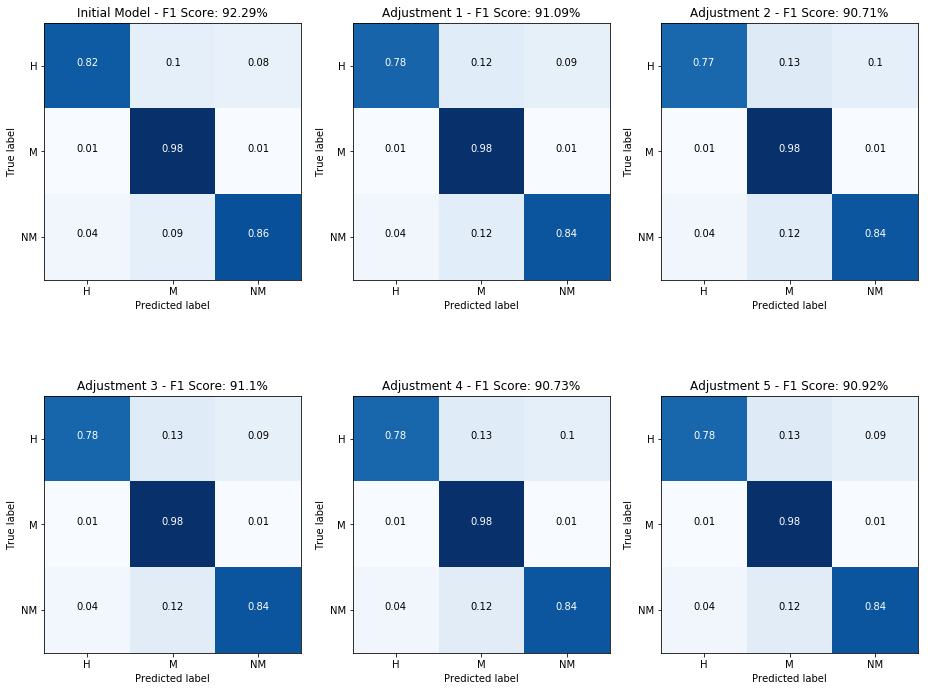

In [141]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13,13))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()
cmap = plt.cm.Blues
classes = ['H', 'M', 'NM']
cm1 = confusion_matrix(idap['IDAP'], idap['PREDICTION'])
cm2 = confusion_matrix(idap['IDAP'], idap['PREDICTION_ADJ_1'])
cm3 = confusion_matrix(idap['IDAP'], idap['PREDICTION_ADJ_2'])
cm4 = confusion_matrix(idap['IDAP'], idap['PREDICTION_ADJ_3'])
cm5 = confusion_matrix(idap['IDAP'], idap['PREDICTION_ADJ_4'])
cm6 = confusion_matrix(idap['IDAP'], idap['PREDICTION_ADJ_5'])
cm7 = confusion_matrix(idap['IDAP'], idap['PREDICTION_ADJ_6'])
cm8 = confusion_matrix(idap['IDAP'], idap['PREDICTION_ADJ_7'])
cm9 = confusion_matrix(idap['IDAP'], idap['PREDICTION_ADJ_8'])
cms = [cm1, cm2, cm3, cm4, cm5, cm6]
axes = [ax0, ax1, ax2, ax3, ax4, ax5]
names = ['Initial Model', 'Adjustment 1', 'Adjustment 2', 'Adjustment 3', 'Adjustment 4', 'Adjustment 5']
predictions = [idap['PREDICTION'], idap['PREDICTION_ADJ_1'], idap['PREDICTION_ADJ_2'], \
               idap['PREDICTION_ADJ_3'], idap['PREDICTION_ADJ_4'], idap['PREDICTION_ADJ_5']]

for ax, cm, name, prediction in zip(axes, cms, names, predictions):
    np.set_printoptions(precision=2)

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(name + ' - {0}'.format("F1 Score: {0:.4g}%".format(f1_score(idap['IDAP'], prediction, average='weighted')*100)))
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')


In [134]:
prediction_adj_count_raw = idap.groupby(['PERTYPE', 'PREDICTION']).count()
prediction_adj_count_raw.reset_index(inplace=True)
prediction_adj_count_raw = prediction_adj_count_raw[['PERTYPE', 'PREDICTION', 'PERNO']]
prediction_adj_count_raw.columns = ['PERTYPE', 'PREDICTION', 'COUNT']

prediction_adj_count = idap.groupby(['PERTYPE', 'PREDICTION_ADJ_1']).count()
prediction_adj_count.reset_index(inplace=True)
prediction_adj_count = prediction_adj_count[['PERTYPE', 'PREDICTION_ADJ_1', 'PERNO']]
prediction_adj_count.columns = ['PERTYPE', 'PREDICTION_ADJ_1', 'COUNT']

prediction_adj_count_2 = idap.groupby(['PERTYPE', 'PREDICTION_ADJ_2']).count()
prediction_adj_count_2.reset_index(inplace=True)
prediction_adj_count_2 = prediction_adj_count_2[['PERTYPE', 'PREDICTION_ADJ_2', 'PERNO']]
prediction_adj_count_2.columns = ['PERTYPE', 'PREDICTION_ADJ_2', 'COUNT']

prediction_adj_count_3 = idap.groupby(['PERTYPE', 'PREDICTION_ADJ_3']).count()
prediction_adj_count_3.reset_index(inplace=True)
prediction_adj_count_3 = prediction_adj_count_3[['PERTYPE', 'PREDICTION_ADJ_3', 'PERNO']]
prediction_adj_count_3.columns = ['PERTYPE', 'PREDICTION_ADJ_3', 'COUNT']

prediction_adj_count_4 = idap.groupby(['PERTYPE', 'PREDICTION_ADJ_4']).count()
prediction_adj_count_4.reset_index(inplace=True)
prediction_adj_count_4 = prediction_adj_count_4[['PERTYPE', 'PREDICTION_ADJ_4', 'PERNO']]
prediction_adj_count_4.columns = ['PERTYPE', 'PREDICTION_ADJ_4', 'COUNT']

prediction_adj_count_5 = idap.groupby(['PERTYPE', 'PREDICTION_ADJ_5']).count()
prediction_adj_count_5.reset_index(inplace=True)
prediction_adj_count_5 = prediction_adj_count_5[['PERTYPE', 'PREDICTION_ADJ_5', 'PERNO']]
prediction_adj_count_5.columns = ['PERTYPE', 'PREDICTION_ADJ_5', 'COUNT']

prediction_adj_count_6 = idap.groupby(['PERTYPE', 'PREDICTION_ADJ_6']).count()
prediction_adj_count_6.reset_index(inplace=True)
prediction_adj_count_6 = prediction_adj_count_6[['PERTYPE', 'PREDICTION_ADJ_6', 'PERNO']]
prediction_adj_count_6.columns = ['PERTYPE', 'PREDICTION_ADJ_6', 'COUNT']

prediction_adj_count_7 = idap.groupby(['PERTYPE', 'PREDICTION_ADJ_7']).count()
prediction_adj_count_7.reset_index(inplace=True)
prediction_adj_count_7 = prediction_adj_count_7[['PERTYPE', 'PREDICTION_ADJ_7', 'PERNO']]
prediction_adj_count_7.columns = ['PERTYPE', 'PREDICTION_ADJ_7', 'COUNT']

In [135]:
survey_count = idap.groupby(['PERTYPE', 'IDAP']).count()
survey_count.reset_index(inplace=True)
survey_count = survey_count[['PERTYPE', 'IDAP', 'PERNO']]
survey_count.columns = ['PERTYPE', 'IDAP', 'COUNT']

In [137]:
init_notebook_mode(connected=True)
for pertype in survey_count.PERTYPE.unique():
    predictions_raw = prediction_adj_count_raw[prediction_adj_count_raw['PERTYPE'] == pertype]
    predictions = prediction_adj_count[prediction_adj_count['PERTYPE'] == pertype]
    predictions_2 = prediction_adj_count_2[prediction_adj_count_2['PERTYPE'] == pertype]
    predictions_3 = prediction_adj_count_3[prediction_adj_count_3['PERTYPE'] == pertype]
    predictions_4 = prediction_adj_count_4[prediction_adj_count_4['PERTYPE'] == pertype]
    predictions_5 = prediction_adj_count_5[prediction_adj_count_5['PERTYPE'] == pertype]
    survey = survey_count[survey_count['PERTYPE'] == pertype]
    trace1 = go.Bar(
        x=survey['IDAP'],
        y=survey['COUNT'],
        name='Survey'
    ) 
    trace2 = go.Bar(
        x=predictions_raw['PREDICTION'],
        y=predictions_raw['COUNT'],
        name='Initial Model'
    )
    trace3 = go.Bar(
        x=predictions['PREDICTION_ADJ_1'],
        y=predictions['COUNT'],
        name='Adjustment 1'
    )
    trace4 = go.Bar(
        x=predictions_2['PREDICTION_ADJ_2'],
        y=predictions_2['COUNT'],
        name='Adjustment 2'
    )
    trace5 = go.Bar(
        x=predictions_3['PREDICTION_ADJ_3'],
        y=predictions_3['COUNT'],
        name='Adjustment 3'
    )
    trace6 = go.Bar(
        x=predictions_4['PREDICTION_ADJ_4'],
        y=predictions_4['COUNT'],
        name='Adjustment 4'
    )
    trace7 = go.Bar(
        x=predictions_5['PREDICTION_ADJ_5'],
        y=predictions_5['COUNT'],
        name='Adjustment 5'
    )
    data = [trace1, trace2, trace3, trace4, trace5, trace6, trace7]
    layout = go.Layout(
        barmode='group',
        title=pertype
    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig)